In [94]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

sys.path.insert(0,'../')
from nps_model_functions import *
from environment import env
config = env.env()
#sys.path.insert(0,'../03_nps_models')


In [96]:
#As files start with digits, running files to access functions
%cd ../03_nps_models
%run '05_nltk_model.ipynb'
%run '06_spacy_model.ipynb'
%cd ../06_nps_evaluation/

In [3]:
test_data = pd.read_csv('../02_nps_api_data/testing_queries.csv')
test_data.columns = ['query', 'intent', 'endpoint', 'parkcode']
test_data.head()

,query,intent,endpoint,parkcode
0,Give me information on De Soto,description,parks,deso
1,Give me information on Bent's Old Fort Nationa...,description,parks,beol
2,Give me information on Vicksburg National Mili...,description,parks,vick
3,Give me information on Appomattox,description,parks,apco
4,Give me information on Dinosaur,description,parks,dino


In [4]:
len(test_data)

888

In [5]:
#smaller test size for now
test_data = test_data.sample(100, random_state=10)

GPT

In [3]:
# Amenities
query = 'List the amenities at Zion'
endpoint, parkcode, intent = nps_model_functions.get_params(query)
print(endpoint, parkcode, intent)


amenities zion amenities


In [7]:
def add_gpt(query_df):
    gpt_df = query_df.apply(lambda x: nps_model_functions.get_params(x['query']), result_type='expand', axis=1)
    gpt_df.columns = ['gpt_endpoint', 'gpt_parkcode', 'gpt_intent']
    query_df = pd.concat([query_df, gpt_df], axis=1)
    #query_df['gpt_endpoint'], query_df['gpt_park_code'],query_df['gpt_intent'] = [nps_model_functions.get_params(x) for x in query_df['query']]
    return query_df

In [10]:
test_data = add_gpt(test_data)
#2m 42s for 100 samples

In [ ]:
#Pause for 61 minutes to rest API - for when full 1k sample size called
time.sleep(3660)

NLTK

In [97]:
# From '06_nltk_model.ipynb'
nltk_model_functions = NLTKModelFunctions(config, park_csv_path)

In [98]:
query = 'What state is Green Springs in?'
endpoint, park_code, intent, output = nltk_model_functions.api_call(query)
print(endpoint, park_code, intent)

parks grsp state


In [134]:
def add_nltk(query_df):
    nltk_model_functions = NLTKModelFunctions(config, park_csv_path)

    nltk_df = query_df.apply(lambda x: nltk_model_functions.api_call(x['query']), result_type='expand', axis=1)
    nltk_df = nltk_df.iloc[:,:-1]
    nltk_df.columns = ['nltk_endpoint', 'nltk_parkcode', 'nltk_intent']
    query_df = pd.concat([query_df, nltk_df], axis=1)
    query_df = query_df.fillna('none')
    
    return query_df

In [135]:
test_data = add_nltk(test_data)
# 26.2s for 100 samples

In [ ]:
#Pause for 61 minutes to rest API - for when full 1k sample size called
time.sleep(3660)

Spacy

In [15]:
# From '06_spacy_model.ipynb'
spacy_model_functions = SpaCyModelFunctions(config, park_csv_path)

In [16]:
def add_spacy(query_df):
    spacy_model_functions = SpaCyModelFunctions(config, park_csv_path)

    spacy_df = query_df.apply(lambda x: spacy_model_functions.api_call(x['query']), result_type='expand', axis=1)
    spacy_df = spacy_df.iloc[:,:-1]
    spacy_df.columns = ['spacy_endpoint', 'spacy_parkcode', 'spacy_intent']
    query_df = pd.concat([query_df, spacy_df], axis=1)
    query_df = query_df.fillna('none')
    
    return query_df

In [ ]:
query = 'What state is Green Springs in?'
endpoint, park_code, intent, output = spacy_model_functions.api_call(query)
print(endpoint, park_code, intent, output)

In [17]:
test_data = add_spacy(test_data)
#28.6s for 100 samples

In [137]:
test_data.to_pickle("new_test.pkl")

In [138]:
test_data.head()

,query,intent,endpoint,parkcode,gpt_endpoint,gpt_parkcode,gpt_intent,spacy_endpoint,spacy_parkcode,spacy_intent,nltk_endpoint,nltk_parkcode,nltk_intent
431,Please provide the full name of Fredericksburg...,fullname,parks,frsp,parks,frsp,fullname,parks,frsp,other,parks,frsp,other
349,Please provide the full name of Cane River?,fullname,parks,cari,parks,cari,fullname,Park not found in the query. Please provide a ...,none,none,Park not found in the query. Please provide a ...,none,none
605,What services are there at Effigy Mounds?,amenities,amenities,efmo,amenities,efmo,amenities,Park not found in the query. Please provide a ...,none,none,Park not found in the query. Please provide a ...,none,none
192,Where is Rainbow Bridge?,address,parks,rabr,parks,rabr,address,Park not found in the query. Please provide a ...,none,none,Park not found in the query. Please provide a ...,none,none
849,Does it cost money to visit Fort Stanwix Natio...,feespass,feespasses,fost,fees,fost,feespass,parks,fost,other,parks,fost,other


Model Accuracy

In [139]:
def plot_accuracy(df, metric): 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[metric], palette='YlGn')
    #sns.barplot(x='RecreationVisits', y='Full_ParkName', data=df, palette='YlGn')
    plt.xlabel('API Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy on {metric}')
    plt.show()

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_2625/1373879499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


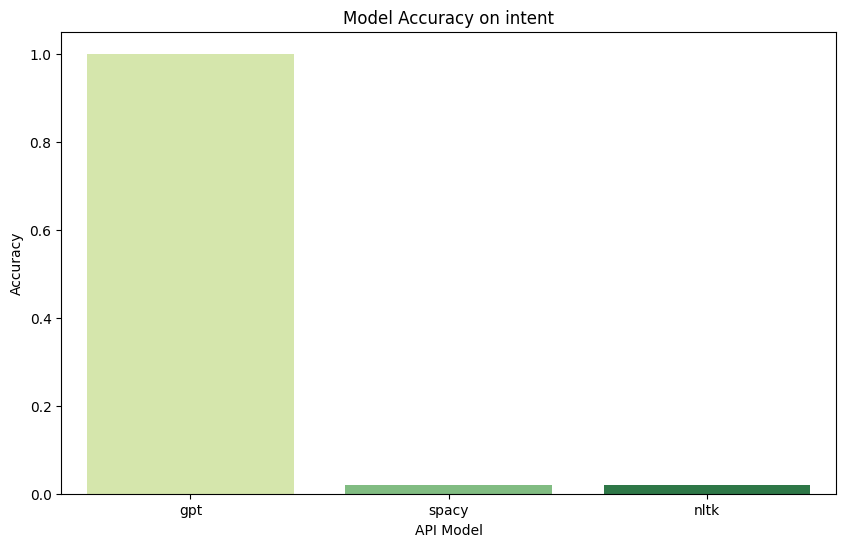

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_2625/1373879499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


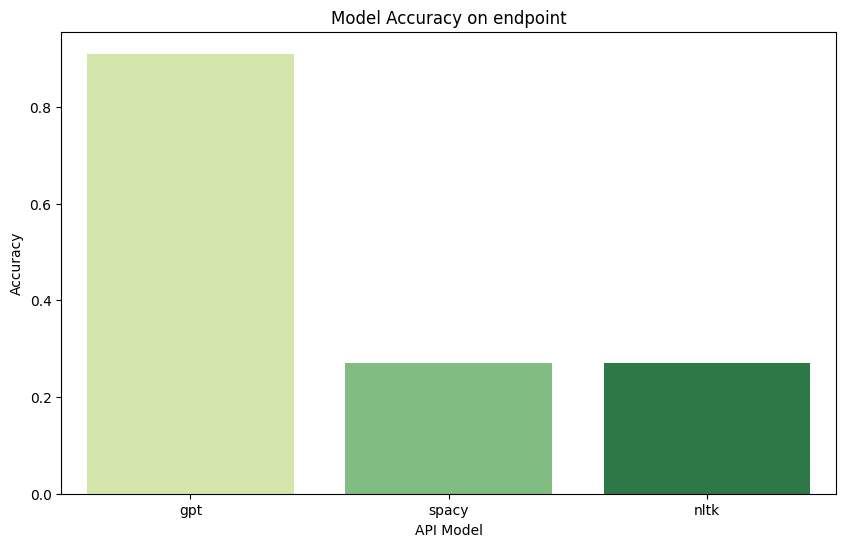

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_2625/1373879499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


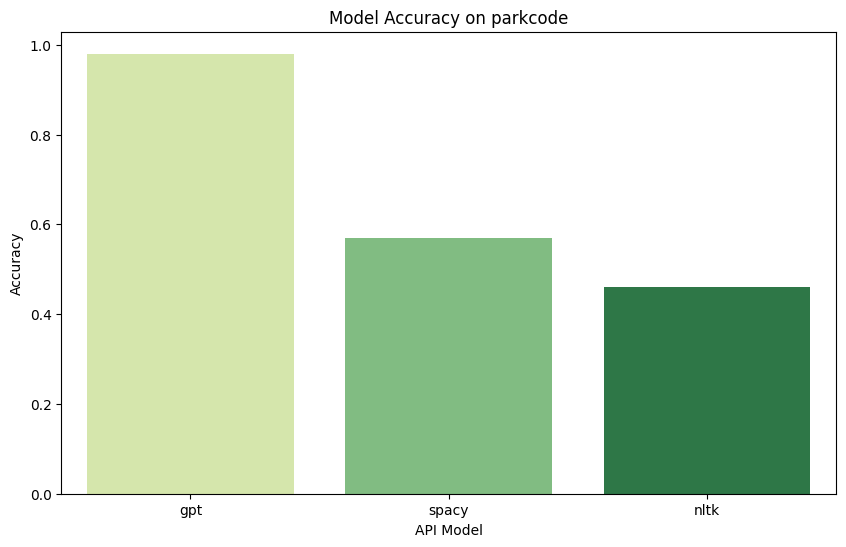

In [140]:
def model_accuracy (df, metrics, models):
    acc_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        for model in models:
            acc_df.loc[model,metric] = len(df.query(f'{metric}=={model}_{metric}'))/len(df)
        plot_accuracy(acc_df, metric)
    return acc_df

accuracy_df = model_accuracy(test_data, ['intent', 'endpoint', 'parkcode'], ['gpt', 'spacy', 'nltk'])



In [141]:
accuracy_df

,intent,endpoint,parkcode
gpt,1.0,0.91,0.98
spacy,0.02,0.27,0.57
nltk,0.02,0.27,0.46


In [22]:
accuracy_df

,intent,endpoint,parkcode
gpt,1.0,0.91,0.98
spacy,0.02,0.27,0.57


Errors

In [142]:
def top_errors (df, metrics, models):
    errors_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        right = '&'.join([f'{metric}=={model}_{metric}' for model in models])
        wrong = '&'.join([f'{metric}!={model}_{metric}' for model in models])
        errors_df.loc['total', metric] = len(df)
        errors_df.loc['all_right', metric] = len(df.query(right))
        errors_df.loc['all_wrong', metric] = len(df.query(wrong))
        for indx, model in enumerate(models):
            other_models = models[:indx]+models[indx+1:]
            right_model = '&'.join([f'{metric}=={model}_{metric}']+[f'{metric}!={mod}_{metric}' for mod in other_models])
            wrong_model = '&'.join([f'{metric}!={model}_{metric}']+[f'{metric}=={mod}_{metric}' for mod in other_models])
            errors_df.loc[f'only_{model}', metric] = len(df.query(right_model))
            errors_df.loc['_and_'.join([mod for mod in other_models])] = len(df.query(wrong_model))
    return errors_df

errors = top_errors(test_data, ['intent', 'endpoint', 'parkcode'], ['gpt', 'spacy', 'nltk'])
errors

,intent,endpoint,parkcode
total,100,100,100
all_right,2,27,44
all_wrong,0,9,0
only_gpt,98,64,43
spacy_and_nltk,2,2,2
only_spacy,0,0,0
gpt_and_nltk,0,0,0
only_nltk,0,0,0
gpt_and_spacy,11,11,11


In [220]:
errors

,intent,endpoint,parkcode
total,100,100,100
right,2,27,47
wrong,0,9,13


In [24]:
errors

,intent,endpoint,parkcode
total,100,100,100
right,2,27,55
wrong,0,9,0


In [143]:
def find_wrong(df, metric, model):
    wrong = df.query(f'{metric}!={model}_{metric}')
    wrong = wrong[[metric, f'{model}_{metric}']].value_counts()

    return wrong

In [56]:
find_wrong(test_data, 'intent', 'gpt')

Series([], Name: count, dtype: int64)

In [57]:
find_wrong(test_data, 'endpoint', 'gpt')

endpoint    gpt_endpoint
feespasses  fees            9
Name: count, dtype: int64

In [58]:
find_wrong(test_data, 'parkcode', 'gpt')

parkcode  gpt_parkcode
fomr      fom             1
jofl      jof             1
Name: count, dtype: int64

In [59]:
find_wrong(test_data, 'intent', 'spacy')

intent       spacy_intent
amenities    none            11
events       other           10
description  other            9
fullname     other            9
alerts       other            8
address      none             7
             other            7
amenities    other            6
feespass     other            6
fullname     none             6
state        none             5
description  none             4
events       none             4
alerts       none             3
feespass     none             3
Name: count, dtype: int64

In [60]:
find_wrong(test_data, 'endpoint', 'spacy')


endpoint    spacy_endpoint                                                
parks       Park not found in the query. Please provide a valid park name.    22
amenities   Park not found in the query. Please provide a valid park name.    11
events      parks                                                             10
alerts      parks                                                              8
amenities   parks                                                              6
feespasses  parks                                                              6
events      Park not found in the query. Please provide a valid park name.     4
alerts      Park not found in the query. Please provide a valid park name.     3
feespasses  Park not found in the query. Please provide a valid park name.     3
Name: count, dtype: int64

In [61]:
find_wrong(test_data, 'parkcode', 'spacy')


parkcode  spacy_parkcode
nebe      none              3
casa      none              3
samo      none              2
elca      none              2
upde      none              2
tuin      none              2
hove      none              2
sand      none              2
cari      none              2
aleu      none              2
saga      none              2
foda      none              2
adam      none              1
roca      none              1
popo      none              1
ston      none              1
tosy      none              1
rabr      none              1
fols      none              1
neri      none              1
efmo      none              1
deso      none              1
cave      none              1
cach      none              1
bisc      none              1
biho      none              1
bepa      none              1
apco      none              1
waca      none              1
Name: count, dtype: int64

In [144]:
find_wrong(test_data, 'intent', 'nltk')

intent       nltk_intent
amenities    none           11
events       other          10
description  other           9
fullname     other           9
alerts       other           8
address      none            7
             other           7
amenities    other           6
feespass     other           6
fullname     none            6
state        none            5
description  none            4
events       none            4
alerts       none            3
feespass     none            3
Name: count, dtype: int64

In [145]:
find_wrong(test_data, 'endpoint', 'nltk')

endpoint    nltk_endpoint                                                 
parks       Park not found in the query. Please provide a valid park name.    22
amenities   Park not found in the query. Please provide a valid park name.    11
events      parks                                                             10
alerts      parks                                                              8
amenities   parks                                                              6
feespasses  parks                                                              6
events      Park not found in the query. Please provide a valid park name.     4
alerts      Park not found in the query. Please provide a valid park name.     3
feespasses  Park not found in the query. Please provide a valid park name.     3
Name: count, dtype: int64

In [146]:
find_wrong(test_data, 'parkcode', 'nltk')

parkcode  nltk_parkcode
kaho      saga             4
nebe      none             3
casa      none             3
samo      none             2
wapa      saga             2
nepe      saga             2
upde      none             2
tuin      none             2
cari      none             2
sand      none             2
aleu      none             2
elca      none             2
foda      none             2
saga      none             2
hove      none             2
roca      none             1
adam      none             1
popo      none             1
ston      none             1
tosy      none             1
waca      none             1
rabr      none             1
kewe      saga             1
neri      none             1
natr      bawa             1
fols      none             1
efmo      none             1
deso      none             1
cave      none             1
cach      none             1
bisc      none             1
biho      none             1
bepa      none             1
apco      none     